# Initialization

In [1]:
# https://github.com/ray-project/ray/blob/master/rllib/examples/sb2rllib_rllib_example.py
import ray
from ray import tune, air
import ray.rllib.algorithms.ppo as ppo
from IPython.display import display, clear_output
from time import sleep
from glob import glob
from pathlib import Path
from tqdm import tqdm
from itertools import count
import matplotlib.pyplot as plt

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-01-15 18:59:04,308	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [3]:
# env config
import gymnasium as gym
import platoonenv

env_name = "Platoon-v5"
env_config=dict(
    num_vehicles=20,
    steps_before_truncation=200,
    cycle_interval=1,
    cycle_num=1,
    attack_interval=1,
)
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config=env_config,
)

print(env_name,"\n------------------")
print("reward_threshold", env.spec.reward_threshold)
print("max_episode_steps", env.spec.max_episode_steps)

Platoon-v5 
------------------
reward_threshold None
max_episode_steps None


In [4]:
# env preview
env.reset()
rewards = [] 
for step in count():
    action = env.action_space.sample()
    obs, reward, done, trunc, info = env.step(action)
    rewards.append(float(reward))
    # sleep(0.02)
    if done or trunc:
        break

clear_output()
display(env.render())

Canvas(height=5512, width=2520)

In [5]:
from statistics import mean
print(f"finished with {sum(rewards)} reward, {mean(rewards)} mean reward, {max(rewards)} max reward, {step} steps")
print(rewards[:10])
print(rewards[-10:])

finished with -2.1379999999999986 reward, -0.01063681592039801 mean reward, -0.007 max reward, 200 steps
[-0.0095, -0.0095, -0.009, -0.009, -0.0085, -0.0085, -0.0085, -0.0085, -0.008, -0.0085]
[-0.0095, -0.0105, -0.0105, -0.01, -0.01, -0.011, -0.011, -0.0105, -0.0105, -0.0085]


In [6]:
from ray.rllib.utils import check_env

check_env(env)

2023-01-15 18:59:08,695	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [7]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig

config = (
    PPOConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=10)
    # .rollouts(num_rollout_workers=0) # curiosity doesn't support parallelism
    .resources(num_gpus=1)
    # .exploration( # https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#curiosity-icm-intrinsic-curiosity-module
    #     exploration_config={
    #         "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    #         "eta": 1.0,  # Weight for intrinsic rewards before being added to extrinsic ones.
    #         "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    #         "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    #         # Setup of the feature net (used to encode observations into feature (latent) vectors).
    #         "feature_net_config": {
    #             "fcnet_hiddens": [],
    #             "fcnet_activation": "relu",
    #         },
    #         "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    #         "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    #         "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    #         "forward_net_activation": "relu",  # Activation of the "forward" model.
    #         "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    #         # Specify, which exploration sub-type to use (usually, the algo's "default"
    #         # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
    #         "sub_exploration": {
    #             "type": "StochasticSampling",
    #         }
    #     }
    # )
)
config.horizon = env.spec.max_episode_steps
config.lr = 0.0001
config.create_env_on_local_worker=True

In [8]:
algo = config.build()

(RolloutWorker pid=2560) 2023-01-15 18:59:21,185	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=2560) 2023-01-15 18:59:21,238	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=2560) 2023-01-15 18:59:21,239	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=7248) 2023-01-15 18:59:21,342	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=7248) 2023-01-15 18:59:21,342	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=22744) 2023-01-15 18:59:21,355	INFO policy.py:1196 -- Policy (worker=10) running on CPU.
(RolloutWorker pid=22744) 2023-01-15 18:59:21,355	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=10520) 2023-01-15 18:59:21,335	INFO policy

In [9]:
config.env_config

{'num_vehicles': 20,
 'steps_before_truncation': 200,
 'cycle_interval': 1,
 'cycle_num': 1,
 'attack_interval': 1}

In [10]:
config.to_dict()

{'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'num_gpus': 1,
 'num_cpus_per_worker': 1,
 'num_gpus_per_worker': 0,
 '_fake_gpus': False,
 'custom_resources_per_worker': {},
 'placement_strategy': 'PACK',
 'eager_tracing': False,
 'eager_max_retraces': 20,
 'tf_session_args': {'intra_op_parallelism_threads': 2,
  'inter_op_parallelism_threads': 2,
  'gpu_options': {'allow_growth': True},
  'log_device_placement': False,
  'device_count': {'CPU': 1},
  'allow_soft_placement': True},
 'local_tf_session_args': {'intra_op_parallelism_threads': 8,
  'inter_op_parallelism_threads': 8},
 'env': 'Platoon-v5',
 'env_config': {'num_vehicles': 20,
  'steps_before_truncation': 200,
  'cycle_interval': 1,
  'cycle_num': 1,
  'attack_interval': 1},
 'observation_space': None,
 'action_space': None,
 'env_task_fn': None,
 'render_env': False,
 'clip_rewards': None,
 'normalize_actions': True,
 'clip_actions': False,
 'disable_env_checking': False,
 'is_atari': None

In [11]:
import ipywidgets as widgets

save_dir = Path("saved_models",f"{env_name}-curious-{env_config['num_vehicles']}vehicles")
save_dir.mkdir(parents=True, exist_ok=True)

checkpoints = sorted(glob(str(Path("saved_models","**","checkpoint_*"))))
checkpoint_path = sorted(glob(str(save_dir / "*")))[-1]

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=checkpoint_path,
    description='Checkpoint:'
)

def on_change(change):
    global checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        checkpoint_path = change['new']

w.observe(on_change)
display(w)


IndexError: list index out of range

In [ ]:
print(f"Restoring from checkpoint: {checkpoint_path}")
algo.restore(checkpoint_path)

2023-01-15 11:28:11,779	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v4-curious-20vehicles\checkpoint_000288
2023-01-15 11:28:11,780	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 288, '_timesteps_total': None, '_time_total': 4482.512967348099, '_episodes_total': 46310}


Restoring from checkpoint: saved_models\Platoon-v4-curious-20vehicles\checkpoint_000288


# Training

In [12]:
def plot(rewards_history):
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.title("Training...")
    plt.xlabel("Step")
    plt.ylabel("Rewards")
    plt.plot([x["episode_reward_mean"] for x in rewards_history])
    plt.show()

In [13]:
results_history = []

In [29]:
skip_training = True
w = widgets.Dropdown(
    value=skip_training,
    description="Skip training?",
    options=[True, False],
)
def on_change(change):
    global skip_training
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        skip_training = change['new']
w.observe(on_change)
display(w)

Dropdown(description='Skip training?', options=(True, False), value=True)

changed to False


In [30]:
train_steps = 500
plot_every = 1

with tqdm(total=train_steps) as pbar:
    for i in count() if train_steps == 0 else range(train_steps):
        if skip_training: 
            print("skipping training")
            break
        try:
            results = algo.train()
        except KeyboardInterrupt:
            print("Interrupting training")
            checkpoint_path = algo.save(save_dir)
            print(f"Checkpoint saved at: {checkpoint_path}")
            break
        pbar.set_description(f"reward mean={results['episode_reward_mean']:.02f}")
        results_history.append(results)
        pbar.update()
        if i % plot_every == 0:
            plot(results_history)
            pbar.display()
        

  0%|          | 0/500 [00:00<?, ?it/s](RolloutWorker pid=2560) 2023-01-15 19:02:59,861	INFO rollout_worker.py:905 -- Generating sample batch of size 400
(RolloutWorker pid=2560) 2023-01-15 19:02:59,862	INFO sampler.py:610 -- Raw obs from env: { 0: { 'agent0': np.ndarray((80,), dtype=float32, min=-6.0, max=0.986, mean=-0.879)}}
(RolloutWorker pid=2560) 2023-01-15 19:02:59,863	INFO sampler.py:611 -- Info return from env: { 0: { 'agent0': { 'modes': np.ndarray((20,), dtype=float32, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=2560)                    'probs': np.ndarray((20,), dtype=float32, min=0.025, max=0.986, mean=0.535),
(RolloutWorker pid=2560)                    'state': np.ndarray((20,), dtype=float32, min=0.0, max=0.0, mean=0.0),
(RolloutWorker pid=2560)                    'values': np.ndarray((20,), dtype=float32, min=-6.0, max=-3.0, mean=-4.05)}}}
(RolloutWorker pid=2560) 2023-01-15 19:02:59,863	INFO sampler.py:853 -- Preprocessed obs: np.ndarray((80,), dtype=float32, min=-

In [26]:
results["info"]

NameError: name 'results' is not defined

In [ ]:
algo.save(save_dir)
# checkpoint path is grabbed by glob when restoring earlier

'saved_models\\Platoon-v4-curious-20vehicles\\checkpoint_000288'

In [ ]:
algo.evaluate()

2023-01-14 23:41:05,377	INFO algorithm.py:882 -- Evaluating current policy for 10 episodes.
2023-01-14 23:41:05,378	INFO rollout_worker.py:905 -- Generating sample batch of size 400
2023-01-14 23:41:05,380	INFO sampler.py:610 -- Raw obs from env: { 0: { 'agent0': np.ndarray((60,), dtype=float32, min=-6.0, max=0.975, mean=-1.165)}}
2023-01-14 23:41:05,380	INFO sampler.py:611 -- Info return from env: {0: {'agent0': {}}}
2023-01-14 23:41:05,381	INFO sampler.py:853 -- Preprocessed obs: np.ndarray((60,), dtype=float32, min=-6.0, max=0.975, mean=-1.165)
2023-01-14 23:41:05,383	INFO sampler.py:858 -- Filtered obs: np.ndarray((60,), dtype=float32, min=-6.0, max=0.975, mean=-1.165)
2023-01-14 23:41:05,385	INFO sampler.py:1144 -- Inputs to compute_actions():

{ 'default_policy': [ { 'data': { 'agent_id': 'agent0',
                                  'env_id': 0,
                                  'info': {},
                                  'obs': np.ndarray((60,), dtype=float32, min=-6.0, max=0.9

{'evaluation': {'episode_reward_max': -1.614499999999997,
  'episode_reward_min': -2.244499999999997,
  'episode_reward_mean': -1.825210526315787,
  'episode_len_mean': 201.0,
  'episode_media': {},
  'episodes_this_iter': 19,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-2.124499999999999,
    -1.8409999999999969,
    -1.891499999999998,
    -1.7399999999999973,
    -1.6244999999999974,
    -2.0269999999999975,
    -1.7284999999999968,
    -1.6489999999999982,
    -2.244499999999997,
    -1.6669999999999996,
    -1.6354999999999966,
    -1.9889999999999983,
    -1.7404999999999966,
    -1.6154999999999982,
    -1.614499999999997,
    -1.7824999999999975,
    -1.8699999999999977,
    -1.7789999999999988,
    -2.114999999999997],
   'episode_lengths': [201,
    201,
    201,
    201,
    201,
    201,
    201,
    201,
    201,
    201,
    201,
    201,
    201,
    201,
    201,
    201,
 

# Evaluate agent

In [ ]:
import numpy as np

In [ ]:
env

<OrderEnforcing<PassiveEnvChecker<InOutValueProbCyclingMonitoringEnv<Platoon-v5>>>>

In [ ]:
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config={
        **env_config,
        "steps_before_truncation": 200
    },
)

seed = int(np.random.randint(0, 100000))
print(f"seed: {seed}")

# evaluate using trained policy
obs, info = env.reset(seed=seed)
actions = []
rewards = []
observations = [obs]
for episode_step in count():
    action = algo.compute_single_action(obs,explore=False)
    next_obs, reward, terminated, truncated, info = env.step(action)
    actions.append(action)
    rewards.append(float(reward))
    observations.append(next_obs)
    if terminated or truncated:
        print(f"ended after step {episode_step} with reward {sum(rewards)} (spec: {env.spec.reward_threshold})")
        break
    obs = next_obs
display(env.render())

# evaluate using random policy for comparison
obs, info = env.reset(seed=seed)
random_actions = []
random_rewards = []
random_observations = [obs]
for episode_step in count():
    action = env.action_space.sample()
    next_obs, reward, terminated, truncated, info = env.step(action)
    random_actions.append(action)
    random_rewards.append(float(reward))
    random_observations.append(next_obs)
    if terminated or truncated:
        print(f"ended after step {episode_step} with reward {sum(random_rewards)} (spec: {env.spec.reward_threshold})")
        break
    obs = next_obs
display(env.render())


seed: 2146
ended after step 200 with reward -1.9665000000000028 (spec: None)


Canvas(height=5512, width=2520)

ended after step 200 with reward -1.9809999999999963 (spec: None)


Canvas(height=5512, width=2520)

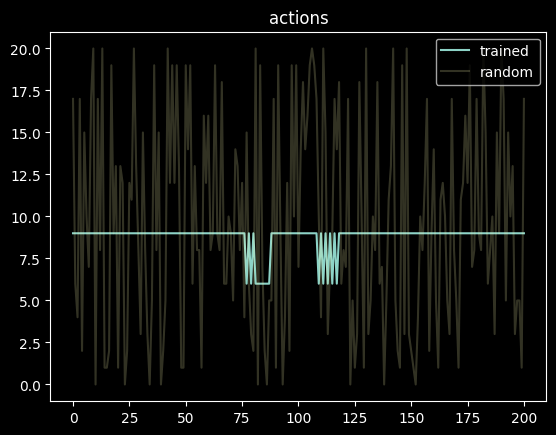

In [ ]:
plt.title("actions")
plt.plot(actions, label="trained")
plt.plot(random_actions, label="random", alpha=0.2)
plt.legend()
plt.show()

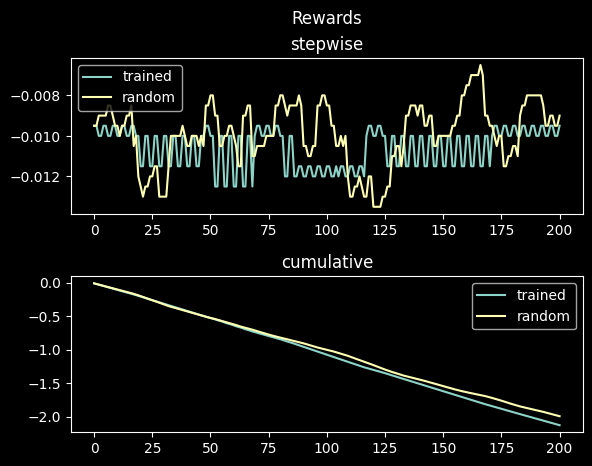

In [ ]:
fig, axs = plt.subplots(2)
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.88,
    # wspace=0.4,
    hspace=0.4,
)
fig.suptitle("Rewards")
axs[0].plot(rewards, label="trained")
axs[0].plot(random_rewards, label="random")
axs[0].set_title("stepwise")
axs[0].legend()

axs[1].plot(np.cumsum(rewards), label="trained")
axs[1].plot(np.cumsum(random_rewards), label="random")
axs[1].set_title("cumulative")
axs[1].legend()

plt.show()

ValueError: operands could not be broadcast together with shapes (20,) (40,) 

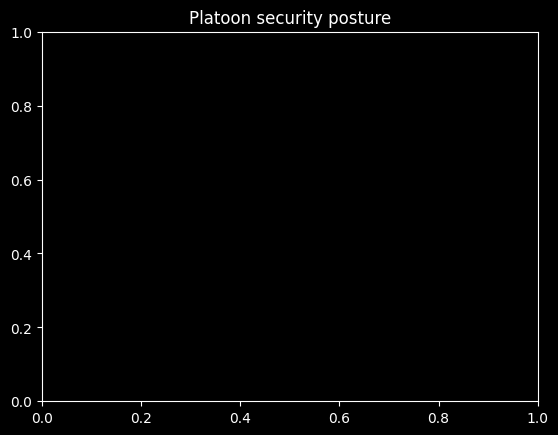

In [ ]:
num_vehicles = env.num_vehicles
def measure(obs):
    membership = obs[:num_vehicles]
    values = obs[num_vehicles:num_vehicles*2]
    probs = obs[num_vehicles*2:]
    
    return np.sum(membership * values * probs)

plt.title("Platoon security posture")
plt.plot([measure(obs) for obs in observations], label="trained")
plt.plot([measure(obs) for obs in random_observations], label="random", alpha=0.2)
plt.legend()
plt.show()